**52100674_52100878_52100322**
* Trần Thị Vẹn
* Nguyễn Đình Danh
* Trương Bình Thuận


Bài 1 (5đ):
Tìm hiểu và trình bày về các biểu diễn token theo phương pháp BPE  (Byte-Pair Encoding). 
Cho các ví dụ về các mô hình có sử dụng tokenizer theo BPE.
***
* So sánh 2 mô hình trên một bài toán cụ thể nào đó có sử dụng BPE và không sử dụng BPE. 
* Lưu ý 2 mô hình này phải được train và test trên cùng một bộ dữ liệu.***

Để so sánh hai mô hình trên một bài toán cụ thể với việc sử dụng BPE (Byte Pair Encoding) và không sử dụng BPE, 
chúng ta có thể sử dụng GPT-2 cho mô hình thứ hai. 
***
* LSTM Model (Không sử dụng BPE): huấn luyện trên dữ liệu ký tự đơn lẻ.
* GPT-2 Model (Sử dụng BPE): Sử dụng GPT-2 với tokenizer BPE.
****

Thuộc tính normalizer của đối tượng tokenizer có phương thức normalize_str() mà ta có thể dùng để thấy cách bước chuẩn hoá được thực hiện:

In [77]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [79]:
#Tiếp theo, ta cần tiền tokenize kho ngữ liệu này thành các từ. Vì ta đang sao chép một bản BPE tokenizer (như GPT-2), ta vẫn có thể sử dụng gpt2 tokenize cho bước pre-tokenization:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [80]:
#Sau đó ta tính tần suất của từng từ trong kho ngữ liệu như khi làm với pre-tokenization:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [81]:
#Tiếp theo chúng ta sẽ tính bộ từ vựng cơ sở từ các kí tự sử dụng trong kho ngữ liệu:

alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [83]:
#Ta cũng có thể thêm các token đặc biệt từ mô hình ở đầu của bộ tự vựng. Trong trường hợp của GPT-2, token đặc biệt duy nhất đó là "<|endoftext|>":
vocab = ["<|endoftext|>"] + alphabet.copy()

In [84]:
#Ta giờ cần phải chia mỗi từ thành các kí tự riêng lẻ để có thể bắt đầu huấn luyện
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [85]:
#Giờ ta đã sẵn sàng để huấn luyện, hãy cùng viết một hàm tính tần suất mỗi cặp. Ta sẽ cần sử dụng nó ở bước huấn luyện:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [86]:
#Hãy nhìn vào một phần từ điẻn sau khi tách:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


In [87]:
#Giờ thì, tìm xem cặp xuất hiện nhiều nhất bằng một vòng lặp nhanh:

best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


In [88]:
#Vậy phép hợp nhất đầu tiên là ('Ġ', 't') -> 'Ġt', và ta thêm 'Ġt' vào bộ từ vựng:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

In [90]:
#Để tiếp tục, ta cần áp dụng sự hợp nhất ở từ điển splits. Hãy cùng viết một hàm khác cho nó:

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [91]:
#Giờ ta có thể nhìn xem kết quả của lần hợp nhất đầu tiên:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [92]:
#Giờ thì ta có tất cả những gì mình cần để lặp cho đến khi ta học tất các các hợp nhất mà ta muốn. Hãy cũng nhắm tới bộ tự vựng có kích cỡ là 50:

vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [93]:
#Kết quả là, chúng ta đã học 19 quy tắc hợp nhất (bộ từ điển gốc có kích cỡ là 31 tương ứng 30 kí tự trong bảng chữ cái cùng một token đặt biệt):

print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


In [94]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


Sử dụng train_new_from_iterator() trên cùng kho ngữ liệu sẽ không mang về kết quả kho ngữ liệu y hệt. 
Đó là bởi khi có sự lựa chọn về cặp có tần suất cao nhất, ta đã chọn cái đầu tiên xuất hiện, 
trong khi thư viện Tokenizers chọn cái đầu tiên dựa trên ID bên trong của nó.

In [95]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])
#Ta có thể thử các này với bất kì đoạn văn nào khác được tạo thành từ các kí tự trong bảng chữ cái:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt

# Load text data
filename = "/kaggle/input/datain5/alice13a.txt"
with open(filename, 'r', encoding='utf-8') as file:
    text = file.read().lower()

# Data preprocessing for LSTM
chars = sorted(list(set(text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

seq_length = 50
dataX = []
dataY = []

for i in range(0, len(text) - seq_length, 1):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])

X = torch.tensor(dataX, dtype=torch.float32).reshape(-1, seq_length, 1) / len(chars)
y = torch.tensor(dataY, dtype=torch.long)

dataset = data.TensorDataset(X, y)

# Check dataset size
if len(dataset) < 2:
    raise ValueError("Dataset too small to be split into train and validation sets.")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

if train_size == 0 or val_size == 0:
    raise ValueError("Train or validation set is empty after splitting.")

train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=False)

# Define CharLSTM Model
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x

hidden_size = 256
num_layers = 2
lstm_model = CharLSTM(len(chars), hidden_size, num_layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)

optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training LSTM Model
n_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    lstm_model.train()
    train_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    lstm_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {correct / total:.4f}')

torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Epoch 1/30, Train Loss: 2.8540, Train Acc: 0.2776, Val Loss: 2.6041, Val Acc: 0.2776
Epoch 2/30, Train Loss: 2.5262, Train Acc: 0.3082, Val Loss: 2.4299, Val Acc: 0.3082
Epoch 3/30, Train Loss: 2.3991, Train Acc: 0.3415, Val Loss: 2.3085, Val Acc: 0.3415
Epoch 4/30, Train Loss: 2.3000, Train Acc: 0.3626, Val Loss: 2.2222, Val Acc: 0.3626
Epoch 5/30, Train Loss: 2.2119, Train Acc: 0.3925, Val Loss: 2.1343, Val Acc: 0.3925
Epoch 6/30, Train Loss: 2.1384, Train Acc: 0.4094, Val Loss: 2.0642, Val Acc: 0.4094
Epoch 7/30, Train Loss: 2.0772, Train Acc: 0.4281, Val Loss: 2.0059, Val Acc: 0.4281
Epoch 8/30, Train Loss: 2.0201, Train Acc: 0.4411, Val Loss: 1.9612, Val Acc: 0.4411
Epoch 9/30, Train Loss: 1.9730, Train Acc: 0.4492, Val Loss: 1.9253, Val Acc: 0.4492
Epoch 10/30, Train Loss: 1.9306, Train Acc: 0.4557, Val Loss: 1.8980, Val Acc: 0.4557
Epoch 11/30, Train Loss: 1.8926, Train Acc: 0.4700, Val Loss: 1.8532, Val Acc: 0.4700
Epoch 12/30, Train Loss: 1.8542, Train Acc: 0.4685, Val Loss: 1

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt

# Load text data
filename = "/kaggle/input/datain5/alice13a.txt"
with open(filename, 'r', encoding='utf-8') as file:
    text = file.read().lower()

# Data preprocessing for GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add pad token
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Resize token embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Split text into smaller chunks for tokenization
chunk_size = 512  # Maximum length for GPT-2 input
chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Tokenize each chunk
input_ids = []
attention_masks = []
for chunk in chunks:
    tokens = tokenizer(chunk, return_tensors="pt", max_length=chunk_size, truncation=True, padding="max_length")
    input_ids.append(tokens['input_ids'])
    attention_masks.append(tokens['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

class TextDataset(data.Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_mask = attention_masks
    def __len__(self):
        return self.input_ids.size(0)
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

dataset = TextDataset(input_ids, attention_masks)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Check dataset size before splitting
if train_size <= 0 or val_size <= 0:
    raise ValueError("Train or validation set size is zero after splitting. Adjust the dataset or check tokenization.")

train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

# Create DataLoader
train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=2, shuffle=False)

# Training GPT-2 Model
optimizer = AdamW(model.parameters(), lr=5e-5)
gpt2_train_losses = []
gpt2_val_losses = []
gpt2_train_accuracies = []
gpt2_val_accuracies = []
n_epochs = 30

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.logits, -1)
        total += input_ids.numel()
        correct += (predicted == input_ids).sum().item()
    
    gpt2_train_losses.append(epoch_loss / len(train_loader))
    gpt2_train_accuracies.append(correct / total)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, -1)
            total += input_ids.numel()
            correct += (predicted == input_ids).sum().item()

    gpt2_val_losses.append(val_loss / len(val_loader))
    gpt2_val_accuracies.append(correct / total)

    print(f'Epoch {epoch+1}/{n_epochs}, GPT-2 Train Loss: {epoch_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {correct / total:.4f}')

torch.save(model.state_dict(), 'gpt2_model.pth')

Epoch 1/30, GPT-2 Train Loss: 2.4119, Train Acc: 0.7057, Val Loss: 1.2481, Val Acc: 0.7057
Epoch 2/30, GPT-2 Train Loss: 1.0257, Train Acc: 0.7036, Val Loss: 0.9828, Val Acc: 0.7036
Epoch 3/30, GPT-2 Train Loss: 0.8935, Train Acc: 0.7028, Val Loss: 0.9265, Val Acc: 0.7028
Epoch 4/30, GPT-2 Train Loss: 0.8244, Train Acc: 0.7027, Val Loss: 0.8911, Val Acc: 0.7027
Epoch 5/30, GPT-2 Train Loss: 0.7686, Train Acc: 0.7023, Val Loss: 0.8730, Val Acc: 0.7023
Epoch 6/30, GPT-2 Train Loss: 0.7217, Train Acc: 0.7020, Val Loss: 0.8683, Val Acc: 0.7020
Epoch 7/30, GPT-2 Train Loss: 0.6800, Train Acc: 0.7027, Val Loss: 0.8662, Val Acc: 0.7027
Epoch 8/30, GPT-2 Train Loss: 0.6407, Train Acc: 0.7025, Val Loss: 0.8798, Val Acc: 0.7025
Epoch 9/30, GPT-2 Train Loss: 0.6014, Train Acc: 0.7021, Val Loss: 0.8949, Val Acc: 0.7021
Epoch 10/30, GPT-2 Train Loss: 0.5510, Train Acc: 0.7028, Val Loss: 0.9128, Val Acc: 0.7028
Epoch 11/30, GPT-2 Train Loss: 0.5037, Train Acc: 0.7031, Val Loss: 0.9599, Val Acc: 0.70

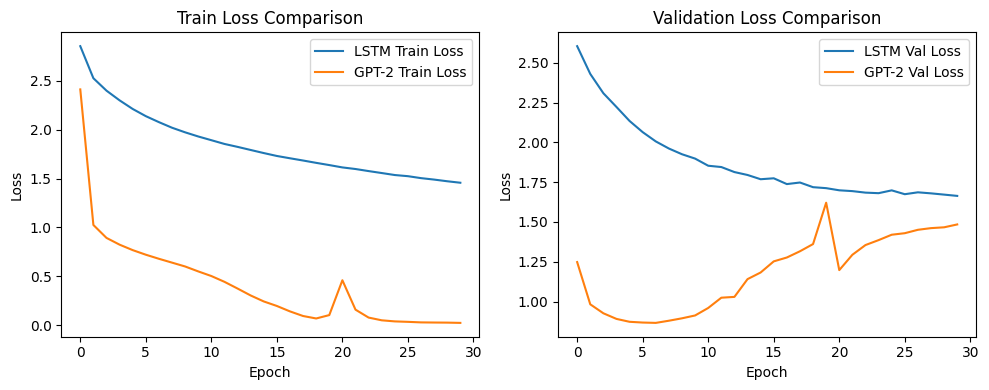

In [56]:
# Plotting the loss and accuracy
plt.figure(figsize=(10, 4))

# Subplot 1 - Train Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='LSTM Train Loss')
plt.plot(gpt2_train_losses, label='GPT-2 Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Comparison')

# Subplot 2 - Validation Loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='LSTM Val Loss')
plt.plot(gpt2_val_losses, label='GPT-2 Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')

plt.tight_layout()  # Đảm bảo không có lấn đè giữa các subplot
plt.show()

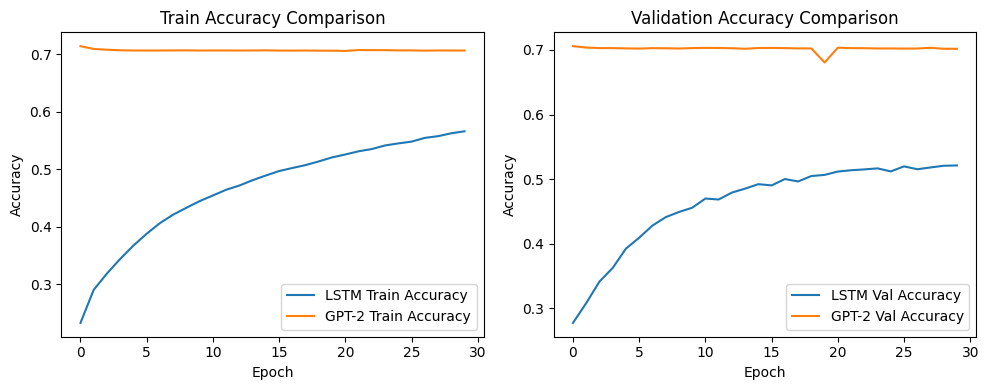

In [58]:
plt.figure(figsize=(10, 4))

# Subplot 1 - Train Accuracy
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='LSTM Train Accuracy')
plt.plot(gpt2_train_accuracies, label='GPT-2 Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Comparison')

# Subplot 2 - Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='LSTM Val Accuracy')
plt.plot(gpt2_val_accuracies, label='GPT-2 Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')

plt.tight_layout()  # Đảm bảo không có lấn đè giữa các subplot
plt.show()

In [76]:
def generate_text(model, seed_text, length=100, temperature=1.0, device="cpu"):
    with torch.no_grad():
        input_sequence = [char_to_int[char] for char in seed_text if char in char_to_int]
        model.eval()
        generated_text = seed_text
        
        for _ in range(length):
            input_tensor = torch.tensor(input_sequence[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)
            output = model(input_tensor)
            output_probs = nn.functional.softmax(output / temperature, dim=1).squeeze().cpu().numpy()
            predicted_index = np.random.choice(len(chars), p=output_probs)
            generated_text += int_to_char[predicted_index]
            input_sequence.append(predicted_index)
        
        return generated_text

# Generate new text
generated_text = generate_text(lstm_model_loaded, seed_text, length=200, temperature=0.7, device=device)

print("Generated Text from LSTM:")
print(generated_text)

Generated Text from LSTM:
Aliceee-  .e  ,e- . . . .e e   . . , . ,e .  :-    ,.  ,e , , .  ,    ,.    , ..- .   .e  .e   . ,  ,e   ,ee-   ,e   ,, , .e . . , s ,e  . . . .e . .  .e  :e, ,  ., ,  ,,  . ,,  .e ,  .e . , .  ,e ,!..   .


In [75]:
def generate_text(model, tokenizer, prompt_text, max_length=100, temperature=1.0):
    input_ids = tokenizer.encode(prompt_text, return_tensors="pt").to('cpu')  # Chuyển sang CPU
    output = model.generate(input_ids, max_length=max_length, temperature=temperature, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Sinh văn bản từ mô hình GPT-2
prompt_text = "Alice"
generated_text = generate_text(model, tokenizer, prompt_text, max_length=100, temperature=0.7)
print("Generated Text from GPT-2:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text from GPT-2:
Alice said to herself, `if thou art to die, I will go with thee.' 
 
  `sure,' said the groom. 
 
  `is to go,' the pilgrim replied in a relieved voice. 
 
  `is to go,' added the groom. 
 
  alice stared intently at the angel, who was walking by, before she 
could react in a word. 
 
  `are you


52100674_52100878_52100322